

### Objective

The Boolean satisfiability (SAT) problem consists in determining whether a Boolean formula F is satisfiable or not. F is represented by a pair (X, C), where X is a set of Boolean variables and C is a set of clauses in Conjunctive Normal Form (CNF). Each clause is a disjunction of literals (a variable or its negation). This problem is one of the most widely studied combinatorial problems in computer science. It is the classic NP-complete problem. Over the past number of decades, a significant amount of research work has focused on solving SAT problems with both complete and incomplete solvers.

One of the most successful approaches is an algorithm portfolio, where a solver is selected among a set of candidates depending on the problem type. Your task is to create a classifier that takes as input the SAT instance's features and identifies the class.

In this project, we represent SAT problems with a vector of 327 features with general information about the problem, e.g., number of variables, number of clauses, the fraction of horn clauses in the problem, etc.


The original dataset is available at:
https://github.com/bprovanbessell/SATfeatPy/blob/main/features_csv/all_features.csv



## Data Preparation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, VarianceThreshold
from pandas.core.common import random_state
from sklearn.linear_model import Lasso
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/andvise/DataAnalyticsDatasets/main/train_dataset.csv", index_col=0)
df.head()

,c,v,clauses_vars_ratio,vars_clauses_ratio,vcg_var_mean,vcg_var_coeff,vcg_var_min,vcg_var_max,vcg_var_entropy,vcg_clause_mean,...,rwh_0_max,rwh_1_mean,rwh_1_coeff,rwh_1_min,rwh_1_max,rwh_2_mean,rwh_2_coeff,rwh_2_min,rwh_2_max,target
0,608,71,8.563380,0.116776,0.045172,0.173688,0.029605,0.060855,2.802758,0.045172,...,5078250.0,1056.695041,1.000000,2.981935e-09,2113.390083,1081.900778,1.0,1.302080e-29,2163.801556,matching
1,615,70,8.785714,0.113821,0.049617,0.168633,0.032520,0.069919,2.607264,0.049617,...,5469376.0,1207.488426,1.000000,6.927306e-28,2414.976852,1186.623627,1.0,3.491123e-120,2373.247255,matching
2,926,105,8.819048,0.113391,0.033385,0.186444,0.017279,0.047516,3.022879,0.033385,...,4297025.0,441.327046,1.000000,1.194627e-76,882.654092,474.697562,1.0,0.000000e+00,949.395124,matching
3,603,70,8.614286,0.116086,0.049799,0.133441,0.033167,0.063018,2.688342,0.049799,...,6640651.0,1181.583331,1.000000,2.437278e-30,2363.166661,1149.059132,1.0,4.670090e-147,2298.118264,matching
4,228,43,5.302326,0.188596,0.067319,0.162581,0.048246,0.087719,2.203308,0.067319,...,2437500.0,1091.423921,0.999966,3.723599e-02,2182.810606,1296.888087,1.0,6.307424e-06,2593.776167,matching


In [ ]:
# Label or target variable
df['target'].value_counts()

tseitin           298
dominating        294
cliquecoloring    268
php               266
subsetcard        263
op                201
tiling            120
5clique           108
3color            104
matching          102
5color             98
4color             98
3clique            98
4clique            94
Name: target, dtype: int64

In [ ]:
df.shape

(2412, 328)

In [ ]:
df.isna().sum().sum()

19756

In [ ]:
df.isnull().sum().sum()

19756

In [ ]:
# FIND COLUMNS WHICH HAVE NULL VALUES AND ITS PERCENTAGE
df.columns[df.isna().any()].tolist()
missing_columns = df.columns[df.isna().any()].tolist()
percent_missing = (df[missing_columns].isna().sum()/len(df))*100
percent_missing

v_nd_p_weights_entropy    100.000000
v_nd_n_weights_entropy    100.000000
c_nd_p_weights_entropy    100.000000
c_nd_n_weights_entropy    100.000000
cg_al_node_entropy          0.082919
cg_al_weights_entropy       0.082919
rg_node_entropy             2.197347
rg_weights_entropy          2.197347
big_node_entropy           18.159204
big_weights_entropy        18.159204
and_node_entropy           40.381426
and_weights_entropy        40.381426
band_node_entropy          56.550580
band_weights_entropy       56.550580
exo_node_entropy           92.164179
exo_weights_entropy        92.164179
dtype: float64

In [ ]:
# Dropping all the columns having missing data above 40%
cols_to_drop = percent_missing[percent_missing > 40]

df_1 = df.drop(columns=list(cols_to_drop.index))
df_1.shape

(2412, 318)

In [ ]:
print(cols_to_drop)

v_nd_p_weights_entropy    100.000000
v_nd_n_weights_entropy    100.000000
c_nd_p_weights_entropy    100.000000
c_nd_n_weights_entropy    100.000000
and_node_entropy           40.381426
and_weights_entropy        40.381426
band_node_entropy          56.550580
band_weights_entropy       56.550580
exo_node_entropy           92.164179
exo_weights_entropy        92.164179
dtype: float64


In [ ]:
df_1.shape

(2412, 318)

In [ ]:
df_s = df_1.select_dtypes(include='object')
df_s.head()

,target
0,matching
1,matching
2,matching
3,matching
4,matching


In [ ]:
X = df_1.drop('target', axis=1)
y = df_1['target']
y.value_counts()

tseitin           298
dominating        294
cliquecoloring    268
php               266
subsetcard        263
op                201
tiling            120
5clique           108
3color            104
matching          102
5color             98
4color             98
3clique            98
4clique            94
Name: target, dtype: int64

### ENCODING THE Target Column

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

### Removing the INFINITE values and replacing them with NaN

In [ ]:
print(np.isinf(X).sum().sum())
X_1 = X.replace([np.inf, -np.inf], np.nan)

820


In [ ]:
# Using imputation to fill the remaining missing values
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
imputed_data = imputer.fit_transform(X_1)
X_2 = pd.DataFrame(imputed_data, columns=X_1.columns)

In [ ]:
# Verifying if any null values still remain after Imputation
X_2.columns[X_2.isna().any()].to_list()

[]

In [ ]:
X_2.shape

(2412, 317)

### Setting the seed for random function before train_test_split. All the steps before this are deterministic and will not have any variability

In [ ]:
random_state_val = 42

In [ ]:
# y = np.argmax(y, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.3, random_state=random_state_val)

In [ ]:
X_train[:5]

,c,v,clauses_vars_ratio,vars_clauses_ratio,vcg_var_mean,vcg_var_coeff,vcg_var_min,vcg_var_max,vcg_var_entropy,vcg_clause_mean,...,rwh_0_min,rwh_0_max,rwh_1_mean,rwh_1_coeff,rwh_1_min,rwh_1_max,rwh_2_mean,rwh_2_coeff,rwh_2_min,rwh_2_max
2115,280.0,29.0,9.655172,0.103571,0.162069,0.573019,0.042857,0.375000,1.842983,0.162069,...,109375.0,109375.0,2.186422e-07,0.0,2.186422e-07,2.186422e-07,2.499507e-22,0.0,2.499507e-22,2.499507e-22
2126,436.0,31.0,14.064516,0.071101,0.170761,0.710254,0.027523,0.449541,2.093567,0.170761,...,78750.0,234375.0,2.843686e-01,1.0,3.093483e-12,5.687371e-01,5.075683e-01,1.0,1.463741e-65,1.015137e+00
458,55.0,15.0,3.666667,0.272727,0.181818,0.000000,0.181818,0.181818,0.000000,0.181818,...,2500.0,2343750.0,1.040557e+04,1.0,1.905487e-22,2.081113e+04,1.041667e+04,1.0,8.927475e-138,2.083333e+04
78,936.0,106.0,8.830189,0.113248,0.030277,0.164145,0.018162,0.041667,2.755228,0.030277,...,1376.0,5859401.0,5.076226e+02,1.0,1.574283e-29,1.015245e+03,5.193923e+02,1.0,9.499499e-134,1.038785e+03
2385,1105.0,46.0,24.021739,0.041629,0.067106,0.036335,0.061538,0.071493,2.090440,0.067106,...,29.0,17578128.0,7.946223e+03,1.0,3.351633e-99,1.589245e+04,7.969101e+03,1.0,0.000000e+00,1.593820e+04


In [ ]:
X_test[:5]

,c,v,clauses_vars_ratio,vars_clauses_ratio,vcg_var_mean,vcg_var_coeff,vcg_var_min,vcg_var_max,vcg_var_entropy,vcg_clause_mean,...,rwh_0_min,rwh_0_max,rwh_1_mean,rwh_1_coeff,rwh_1_min,rwh_1_max,rwh_2_mean,rwh_2_coeff,rwh_2_min,rwh_2_max
1621,231.0,21.0,11.000000,0.090909,0.132344,0.058489,0.121212,0.142857,1.555266,0.132344,...,176.0,7031300.0,17173.635454,1.000000,1.832871e-42,34347.270908,1.705808e+04,1.00000,0.000000e+00,3.411615e+04
2200,739.0,52.0,14.211538,0.070365,0.097117,0.468746,0.051421,0.184032,1.914111,0.097117,...,109375.0,156250.0,0.000006,0.999854,9.410393e-10,0.000013,1.665021e-10,1.00000,8.577272e-32,3.330041e-10
2399,854.0,42.0,20.333333,0.049180,0.067581,0.105414,0.046838,0.079625,2.895668,0.067581,...,10.0,11328130.0,8201.011699,1.000000,1.165219e-74,16402.023398,8.029052e+03,1.00000,0.000000e+00,1.605810e+04
1953,775.0,90.0,8.611111,0.116129,0.033118,0.018366,0.032258,0.033548,0.636514,0.033118,...,625625.0,1640625.0,34.929743,0.999428,1.996977e-02,69.839517,4.823058e+01,0.99921,3.808217e-02,9.642308e+01
1798,647.0,97.0,6.670103,0.149923,0.027215,0.288034,0.013910,0.044822,2.499311,0.027215,...,140625.0,4687500.0,376.466397,1.000000,2.796971e-10,752.932794,4.134127e+02,1.00000,1.738893e-26,8.268253e+02


In [ ]:
X_2[:5]

,c,v,clauses_vars_ratio,vars_clauses_ratio,vcg_var_mean,vcg_var_coeff,vcg_var_min,vcg_var_max,vcg_var_entropy,vcg_clause_mean,...,rwh_0_min,rwh_0_max,rwh_1_mean,rwh_1_coeff,rwh_1_min,rwh_1_max,rwh_2_mean,rwh_2_coeff,rwh_2_min,rwh_2_max
0,608.0,71.0,8.563380,0.116776,0.045172,0.173688,0.029605,0.060855,2.802758,0.045172,...,109385.0,5078250.0,1056.695041,1.000000,2.981935e-09,2113.390083,1081.900778,1.0,1.302080e-29,2163.801556
1,615.0,70.0,8.785714,0.113821,0.049617,0.168633,0.032520,0.069919,2.607264,0.049617,...,1575.0,5469376.0,1207.488426,1.000000,6.927306e-28,2414.976852,1186.623627,1.0,3.491123e-120,2373.247255
2,926.0,105.0,8.819048,0.113391,0.033385,0.186444,0.017279,0.047516,3.022879,0.033385,...,20.0,4297025.0,441.327046,1.000000,1.194627e-76,882.654092,474.697562,1.0,0.000000e+00,949.395124
3,603.0,70.0,8.614286,0.116086,0.049799,0.133441,0.033167,0.063018,2.688342,0.049799,...,1065.0,6640651.0,1181.583331,1.000000,2.437278e-30,2363.166661,1149.059132,1.0,4.670090e-147,2298.118264
4,228.0,43.0,5.302326,0.188596,0.067319,0.162581,0.048246,0.087719,2.203308,0.067319,...,313125.0,2437500.0,1091.423921,0.999966,3.723599e-02,2182.810606,1296.888087,1.0,6.307424e-06,2593.776167


# Tasks

## Basic models and evaluation (5 Marks)

Using Scikit-learn, train and evaluate a decision tree classifier using 70% of the dataset from training and 30% for testing. For this part of the project, we are not interested in optimising the parameters; we just want to get an idea of the dataset.

In [ ]:
from sklearn.tree import DecisionTreeClassifier


simple_decision_tree = DecisionTreeClassifier(random_state=random_state_val)
simple_decision_tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = simple_decision_tree.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9917127071823204


In [ ]:
# Creating a new Dataframe to keep track of Models and their accuracy scores.
df_score = pd.DataFrame({'model_desc': 'simple_decision_tree', 'model_score': [accuracy]}, index=[0])
simple_decision_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
X_train.shape

(1688, 317)

## Robust evaluation

In this section, we are interested in more rigorous techniques by implementing more sophisticated methods, for instance:
* Hold-out and cross-validation.
* Hyper-parameter tuning.
* Feature reduction.
* Feature selection.
* Feature normalisation.



chi2 cannot be done as the data has negative values

Trying Lasso Regression for feature selection as the dataset has many columns which might lead to overfitting

In [ ]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# instantiate a Lasso Regression model
lasso = Lasso(alpha=0.1)

# fit the model to the training data
lasso.fit(X_train_scaled, y_train)

# predict the target variable for the test data
X_test_scaled = scaler.transform(X_test)
y_pred = lasso.predict(X_test_scaled)

# evaluate the model performance
print("R-squared score:", lasso.score(X_test_scaled, y_test))


R-squared score: 0.9001121454464669


In [ ]:
df_score = df_score.append({'model_desc': 'lasso', 'model_score': lasso.score(X_test_scaled, y_test)}, ignore_index=True)

In [ ]:
df_score

,model_desc,model_score
0,simple_decision_tree,0.991713
1,lasso,0.900112


First Trying with feature selection

In [ ]:
# Creating a Pipeline for Decision Tree with Feature selection
# Define the pipeline
pipe_dt = Pipeline(steps=[
     ('var_thresh', VarianceThreshold(threshold=0)),
     ('feature_normalization', StandardScaler()),
     ("feature_selector", SelectKBest()),
     ('model', DecisionTreeClassifier(random_state=random_state_val))
])
param_grid = {
    'model__max_depth': [15, 17, 20, None],
    'model__min_samples_split': [2,3,5],
    "feature_selector__k": [38, 45, 50, 55, 60, 65,70],
}

# Define the cross-validation method
cv = KFold(n_splits=3, shuffle=True)

# Step 6: Perform grid search for hyperparameter tuning and cross-validation
grid_search_dt1 = GridSearchCV(pipe_dt, param_grid=param_grid, cv=cv, n_jobs=-1,scoring='accuracy', verbose=2)
grid_search_dt1.fit(X_train, y_train)


Fitting 3 folds for each of 84 candidates, totalling 252 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('var_thresh',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_normalization',
                                        StandardScaler()),
                                       ('feature_selector', SelectKBest()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selector__k': [38, 45, 50, 55, 60, 65, 70],
                         'model__max_depth': [15, 17, 20, None],
                         'model__min_samples_split': [2, 3, 5]},
             scoring='accuracy', verbose=2)

In [ ]:
from sklearn.metrics import accuracy_score

# Get the best estimator
best_model = grid_search_dt1.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
df_score = df_score.append({'model_desc': 'grid_search_dt1', 'model_score': accuracy}, ignore_index=True)

In [ ]:
# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search_dt1.best_params_)
print("Best Train score:", grid_search_dt1.best_score_)
df_score = df_score.append({'model_desc': 'grid_search_dt1-Best score', 'model_score': grid_search_dt1.best_score_}, ignore_index=True)

# Evaluate the performance of the best estimator on the test set for hold-out validation
score = best_model.score(X_test, y_test)
print("Hold-out validation score:", score)
df_score = df_score.append({'model_desc': 'grid_search_dt1-Hold-out validation score', 'model_score': score}, ignore_index=True)

Best hyperparameters: {'feature_selector__k': 38, 'model__max_depth': 15, 'model__min_samples_split': 5}
Best Train score: 0.9697846016405083
Hold-out validation score: 0.9792817679558011


In [ ]:
# Use cross-validation to evaluate the performance of the best estimator on the entire dataset
scores = cross_val_score(best_model, X_2, y, cv=cv)
print("Cross-validation scores:", scores)

Cross-validation scores: [0.9800995  0.97761194 0.96641791]


In [ ]:
df_score = df_score.append({'model_desc': 'cross_val_score', 'model_score': scores}, ignore_index=True)

In [ ]:
df_score

,model_desc,model_score
0,simple_decision_tree,0.991713
1,lasso,0.900112
2,grid_search_dt1,0.979282
3,grid_search_dt1-Best score,0.969785
4,grid_search_dt1-Hold-out validation score,0.979282
5,cross_val_score,"[0.9800995024875622, 0.9776119402985075, 0.966..."


Trying PCA for dimentionality reduction. These curves will help us in finding the optimal range of features that have maximum variance so we will be using these during our Grid search to find the best param

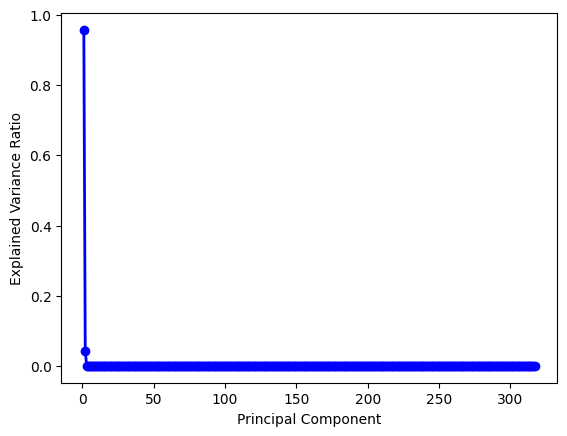

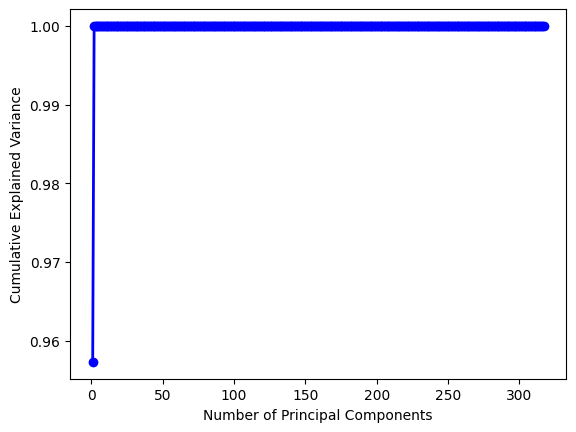

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=317, random_state=random_state_val)
pca.fit(X_train)

# Scree Plot
plt.plot(range(1, 318), pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Cumulative Explained Variance
plt.plot(range(1, 318), np.cumsum(pca.explained_variance_ratio_), 'bo-', linewidth=2)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
# Creating a Pipeline for Decision Tree with PCA
# Define the pipeline
pipe_dt = Pipeline(steps=[
    ('feature_normalization', StandardScaler()),
    ('feature_reduction', PCA(random_state=random_state_val)),
    ('model', DecisionTreeClassifier(random_state=random_state_val))
])
# Focussing the values around max-depth of 25 and feature-reduction of 80 features
param_grid = {
    'model__max_depth': [18, 20, 22, 25],
    'model__min_samples_split': [2,3,5],
    'feature_reduction__n_components': [38, 42, 65, 85, 105]
}

# Define the cross-validation method
cv = KFold(n_splits=3, shuffle=True)

# Step 6: Perform grid search for hyperparameter tuning and cross-validation
grid_search_dt_pca = GridSearchCV(pipe_dt, param_grid=param_grid, cv=cv, n_jobs=-1,scoring='accuracy', verbose=2)
grid_search_dt_pca.fit(X_train, y_train)


Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('feature_normalization',
                                        StandardScaler()),
                                       ('feature_reduction',
                                        PCA(random_state=42)),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_reduction__n_components': [38, 42, 65, 85,
                                                             105],
                         'model__max_depth': [18, 20, 22, 25],
                         'model__min_samples_split': [2, 3, 5]},
             scoring='accuracy', verbose=2)

In [ ]:
from sklearn.metrics import accuracy_score

# Get the best estimator
best_model = grid_search_dt_pca.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
df_score = df_score.append({'model_desc': 'grid_search_dt_pca', 'model_score': accuracy}, ignore_index=True)

Test Accuracy: 0.9571823204419889


In [ ]:
# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search_dt_pca.best_params_)
print("Best Training score:", grid_search_dt_pca.best_score_)

# Evaluate the performance of the best estimator on the test set for hold-out validation
score = grid_search_dt_pca.best_estimator_.score(X_test, y_test)
print("Hold-out validation score:", score)
df_score = df_score.append({'model_desc': 'grid_search_dt_pca-Hold_out_validation_Score', 'model_score': score}, ignore_index=True)

# Use cross-validation to evaluate the performance of the best estimator on the entire dataset
scores = cross_val_score(grid_search_dt_pca.best_estimator_, X_2, y, cv=cv)
print("Cross-validation scores:", scores)

Best hyperparameters: {'feature_reduction__n_components': 42, 'model__max_depth': 18, 'model__min_samples_split': 3}
Best Training score: 0.9289120096753328
Hold-out validation score: 0.9571823204419889
Cross-validation scores: [0.95522388 0.93034826 0.95024876]


In [ ]:
df_score = df_score.append({'model_desc': 'grid_search_dt_pca-CrossValidationScore', 'model_score': scores}, ignore_index=True)
df_score

,model_desc,model_score
0,simple_decision_tree,0.991713
1,lasso,0.900112
2,grid_search_dt1,0.979282
3,grid_search_dt1-Best score,0.969785
4,grid_search_dt1-Hold-out validation score,0.979282
5,cross_val_score,"[0.9800995024875622, 0.9776119402985075, 0.966..."
6,grid_search_dt_pca,0.957182
7,grid_search_dt_pca-Hold_out_validation_Score,0.957182
8,grid_search_dt_pca-CrossValidationScore,"[0.9552238805970149, 0.9303482587064676, 0.950..."


We see that feature selection performs better than PCA so we will be using that going forward

## MOVING AHEAD WITH FEATURE SELECTION AS FEATURE REDUCTION USING PCA IS NOT GIVING AS GOOD RESULTS. MOSTLY BECAUSE WE DONT HAVE ENOUGH NUMBER OF ROWS.

In [ ]:
grid_search_dt1.best_params_['feature_selector__k']

38

In [ ]:

# Define the pipeline
pipe = Pipeline(steps=[
    ('var_thresh', VarianceThreshold(threshold=0)),
    ('feature_normalization', StandardScaler()),
    ("feature_selector", SelectKBest()),
    ('model', None)
])

# Taking the best features that was previously selected by the GridSearch and
# using the same for multi-model GridSearchCV
pipe.set_params(feature_selector__k=grid_search_dt1.best_params_['feature_selector__k'])


# Define the hyperparameters for tuning for each model
param_grids = [
    {
        'model': [RandomForestClassifier(random_state=random_state_val)],
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [18, 20, 22, 25]
    },
    {
        'model': [GradientBoostingClassifier(random_state=random_state_val)],
        'model__n_estimators': [50, 100, 150],
        'model__learning_rate': [0.01, 0.1, 1.0]
    },
    {
        'model': [XGBClassifier(random_state=random_state_val)],
        'model__n_estimators': [50, 100, 150],
        'model__learning_rate': [0.01, 0.1, 1.0]
    }
]

# Define the cross-validation method
cv = KFold(n_splits=3, shuffle=True)

# Create the GridSearchCV object for each model
# Step 6: Perform grid search for hyperparameter tuning and cross-validation
grid_search_multi_model = GridSearchCV(pipe, param_grid=param_grids, cv=3, n_jobs=-1,scoring='accuracy', verbose=2)
grid_search_multi_model.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('var_thresh',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_normalization',
                                        StandardScaler()),
                                       ('feature_selector', SelectKBest(k=38)),
                                       ('model', None)]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestClassifier(max_depth=18,
                                                           random_state=42)],
                          'model__max_depth': [18, 20, 22, 25],
                          'model__n_estimators': [50, 100, 150]},
                         {'mode...
                                                  max_cat_threshold=None,
                                                  max_cat_to_onehot=None,
                                                  max_delta_step=None,
                                                  max_depth=None,
                                                  max_leaves=None,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  monotone_constraints=None,
                                                  n_estimators=100, n_jobs=None,
                                                  num_parallel_tree=None,
                                                  predictor=None,
                                                  random_state=42, ...)],
                          'model__learning_rate': [0.01, 0.1, 1.0],
                          'model__n_estimators': [50, 100, 150]}],
             scoring='accuracy', verbose=2)

In [ ]:
# Get the best estimator
best_model = grid_search_multi_model.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
df_score = df_score.append({'model_desc': 'grid_search_multi_model', 'model_score': accuracy}, ignore_index=True)

Test Accuracy: 1.0


In [ ]:
# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search_multi_model.best_params_)
print("Best Training score:", grid_search_multi_model.best_score_)

# Evaluate the performance of the best estimator on the test set for hold-out validation
score = grid_search_multi_model.best_estimator_.score(X_test, y_test)
print("Hold-out validation score:", score)
df_score = df_score.append({'model_desc': 'Multi Model grid_search-Hold_out_validation_Score', 'model_score': score}, ignore_index=True)

# Use cross-validation to evaluate the performance of the best estimator on the entire dataset
scores = cross_val_score(grid_search_multi_model.best_estimator_, X_2, y, cv=cv)
print("Cross-validation scores:", scores)

Best hyperparameters: {'model': RandomForestClassifier(max_depth=18, random_state=42), 'model__max_depth': 18, 'model__n_estimators': 100}
Best Training score: 0.9911105773383985
Hold-out validation score: 1.0
Cross-validation scores: [0.99751244 0.99378109 0.99751244]


The reason Random Forest is working out better than XGBClassifier is because the number of rows is relatively less than the models.

In [ ]:
df_score = df_score.append({'model_desc': 'Multi Model grid_search-CrossValidationScore', 'model_score': scores}, ignore_index=True)
df_score

,model_desc,model_score
0,simple_decision_tree,0.991713
1,lasso,0.900112
2,grid_search_dt1,0.979282
3,grid_search_dt1-Best score,0.969785
4,grid_search_dt1-Hold-out validation score,0.979282
5,cross_val_score,"[0.9800995024875622, 0.9776119402985075, 0.966..."
6,grid_search_dt_pca,0.957182
7,grid_search_dt_pca-Hold_out_validation_Score,0.957182
8,grid_search_dt_pca-CrossValidationScore,"[0.9552238805970149, 0.9303482587064676, 0.950..."
9,grid_search_multi_model,1.0


In [ ]:
grid_search_multi_model.best_params_['model__n_estimators'], grid_search_multi_model.best_params_['model__max_depth'], grid_search_dt1.best_params_['feature_selector__k']

(100, 18, 38)

In [ ]:
# Define the pipeline
pipe = Pipeline(steps=[
    ('var_thresh', VarianceThreshold(threshold=0)),
    ('feature_normalization', StandardScaler()),
    ("feature_selector", SelectKBest()),
    ('model', RandomForestClassifier(random_state=random_state_val))
])


# Define the hyperparameters for tuning for each model
best_estimator_count = grid_search_multi_model.best_params_['model__n_estimators']
best_max_depth = grid_search_multi_model.best_params_['model__max_depth']
best_features_count = grid_search_dt1.best_params_['feature_selector__k']
param_grids = [
    {
        'model__n_estimators': [best_estimator_count-15, best_estimator_count-5, best_estimator_count, best_estimator_count+5, best_estimator_count+15],
        'model__max_depth': [best_max_depth-5, best_max_depth-4, best_max_depth-2, best_max_depth, best_max_depth+2],
        'feature_selector__k': [best_features_count-20, best_features_count-10, best_features_count, best_features_count+10, best_features_count+10]
    }
]

# Define the cross-validation method
cv = KFold(n_splits=3, shuffle=True)

# Create the GridSearchCV object for each model
# Step 6: Perform grid search for hyperparameter tuning and cross-validation
grid_search_random_forest = GridSearchCV(pipe, param_grid=param_grids, cv=cv, n_jobs=-1,scoring='accuracy', verbose=2)
grid_search_random_forest.fit(X_train, y_train)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('var_thresh',
                                        VarianceThreshold(threshold=0)),
                                       ('feature_normalization',
                                        StandardScaler()),
                                       ('feature_selector', SelectKBest()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'feature_selector__k': [18, 28, 38, 48, 48],
                          'model__max_depth': [13, 14, 16, 18, 20],
                          'model__n_estimators': [85, 95, 100, 105, 115]}],
             scoring='accuracy', verbose=2)

In [ ]:
# Get the best estimator
best_model = grid_search_random_forest.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
df_score = df_score.append({'model_desc': 'grid_search_random_forest', 'model_score': accuracy}, ignore_index=True)

Test Accuracy: 1.0


In [ ]:
# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search_random_forest.best_params_)
print("Best Training score:", grid_search_random_forest.best_score_)

# Evaluate the performance of the best estimator on the test set for hold-out validation
score = grid_search_random_forest.best_estimator_.score(X_test, y_test)
print("Hold-out validation score:", score)
df_score = df_score.append({'model_desc': 'grid_search_random_forest-Hold_out_validation_Score', 'model_score': score}, ignore_index=True)

# Use cross-validation to evaluate the performance of the best estimator on the entire dataset
scores = cross_val_score(grid_search_random_forest.best_estimator_, X_2, y, cv=cv)
print("Cross-validation scores:", scores)
df_score = df_score.append({'model_desc': 'grid_search_random_forest-CrossValidationScore', 'model_score': scores}, ignore_index=True)

Best hyperparameters: {'feature_selector__k': 38, 'model__max_depth': 14, 'model__n_estimators': 85}
Best Training score: 0.9928909902677784
Hold-out validation score: 1.0
Cross-validation scores: [0.99626866 0.99378109 0.99875622]


In [ ]:
grid_search_random_forest.best_params_['model__max_depth'], grid_search_random_forest.best_params_['model__n_estimators'], grid_search_random_forest.best_params_['feature_selector__k']

(14, 85, 38)

In [ ]:
final_pipe = Pipeline(steps=[
    ('var_thresh', VarianceThreshold(threshold=0)),
    ('feature_normalization', StandardScaler()),
    ("feature_selector", SelectKBest(k=grid_search_random_forest.best_params_['feature_selector__k'])),
    ('model', RandomForestClassifier(n_estimators=grid_search_random_forest.best_params_['model__n_estimators'], max_depth=grid_search_random_forest.best_params_['model__max_depth'], random_state=random_state_val))
])

final_pipe.fit(X_2, y)

Pipeline(steps=[('var_thresh', VarianceThreshold(threshold=0)),
                ('feature_normalization', StandardScaler()),
                ('feature_selector', SelectKBest(k=38)),
                ('model',
                 RandomForestClassifier(max_depth=14, n_estimators=85,
                                        random_state=42))])

In [ ]:
# Make predictions on the test set
y_pred = final_pipe.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
# df_score = df_score.append({'model_desc': 'grid_search_random_forest', 'model_score': accuracy}, ignore_index=True)

Test Accuracy: 1.0


In [ ]:
y_pred_full = final_pipe.predict(X_2)
y_pred = final_pipe.predict(X_test)
# Calculate the accuracy score
accuracy_full = accuracy_score(y, y_pred_full)
accuracy_test = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy_test)
print("Full Accuracy:", accuracy_full)

Test Accuracy: 1.0
Full Accuracy: 0.9995854063018242


In [ ]:
import joblib

# Save the model to a file
joblib.dump(final_pipe, 'SAT_model.pkl')


['SAT_model.pkl']

In [ ]:
final_pipe.score(X_test, y_test)

1.0